# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

- raw pixel을 이용해서 linear classifier을 훈련하기보다는 raw pixel에서 얻은 feature를 통해서 linear classifer를 훈련시켜보도록 합시다.

All of your work for this exercise will be done in this notebook.

In [ ]:
from __future__ import print_function

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [ ]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [ ]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat
print(X_train_feats.shape)
# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])
print(X_train_feats.shape)

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [ ]:
# breakpoint()

# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-8, 1e-7, 5e-6, 5e-5, 1e-5]
regularization_strengths = [1e0, 1e1, 5e2, 1e3, 5e3, 1e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.


results = {}
best_val = -1
 # The highest validation accuracy that we have seen so far.
best_svm = None  # The LinearSVM object that achieved the highest validation rate.

for lr in learning_rates :
    for reg in regularization_strengths :
        # 이 하이퍼 파라미터로 모델을 학습한다
        from cs231n.classifiers import LinearSVM
        svm = LinearSVM()
        loss_hist = svm.train(
            X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=False
        )
        # validation set으로 모델의 성능을 검증한다
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        training_accuracy = np.mean(y_train==y_train_pred)
        validation_accuracy = np.mean(y_val == y_val_pred)
        results[(lr,reg)] = (training_accuracy, validation_accuracy)
        if validation_accuracy > best_val :
            best_val = validation_accuracy
            # if not (best_svm is svm):
                # print("서로 다른 객체입니다")
            best_svm = svm



################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print(
        "lr %e reg %e train accuracy: %f val accuracy: %f"
        % (lr, reg, train_accuracy, val_accuracy)
    )

print("best validation accuracy achieved during cross-validation: %f" % best_val)



In [ ]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

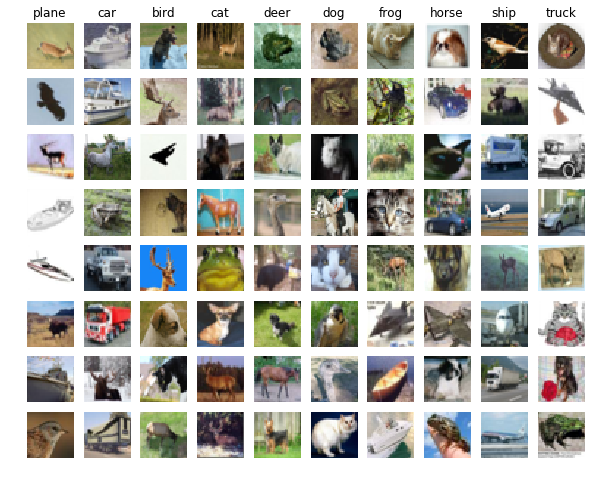

In [43]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".
# 잘못 분류한 사진들의 예시

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    # print((y_test != cls) & (y_test_pred == cls))
    #실제로는 cls가 아닌 다른 클래스인데, SVM이 cls 클래스로 인식한 것
    # 조건에 맞는 인덱스 반환, 튜플 형태, row index만 취한다
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    # print('idxs : ', idxs)
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    # print('idxs : ', idxs)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [ ]:
print(X_train_feats.shape)

(49000, 155)
iteration 0 / 10000: loss 2.302668
iteration 100 / 10000: loss 2.261613
iteration 200 / 10000: loss 2.216260
iteration 300 / 10000: loss 2.183327
iteration 400 / 10000: loss 2.215169
iteration 500 / 10000: loss 2.261402
iteration 600 / 10000: loss 2.202766
iteration 700 / 10000: loss 2.243741
iteration 800 / 10000: loss 2.175860
iteration 900 / 10000: loss 2.155785
iteration 1000 / 10000: loss 2.194987
iteration 1100 / 10000: loss 2.161555
iteration 1200 / 10000: loss 2.159854
iteration 1300 / 10000: loss 2.182051
iteration 1400 / 10000: loss 2.160194
iteration 1500 / 10000: loss 2.156209
iteration 1600 / 10000: loss 2.136538
iteration 1700 / 10000: loss 2.122928
iteration 1800 / 10000: loss 2.182298
iteration 1900 / 10000: loss 2.183178
iteration 2000 / 10000: loss 2.131909
iteration 2100 / 10000: loss 2.132069
iteration 2200 / 10000: loss 2.117089
iteration 2300 / 10000: loss 2.145134
iteration 2400 / 10000: loss 2.105593
iteration 2500 / 10000: loss 2.164021
iteration 2

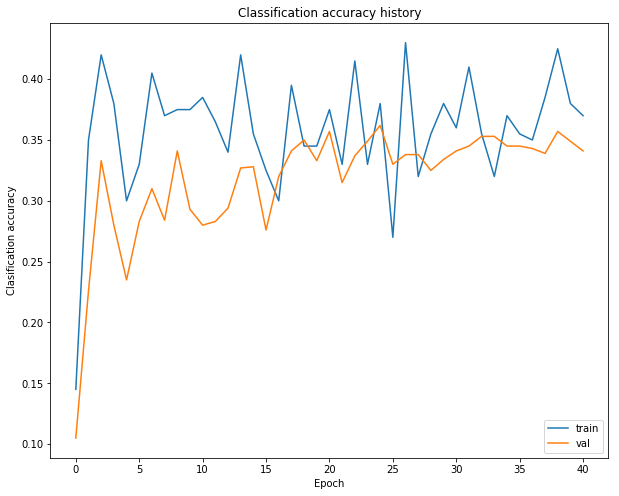

In [56]:
from cs231n.classifiers.neural_net import TwoLayerNet
print(X_train_feats.shape)
input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
stats = net.train(X_train_feats, y_train, X_val_feats, y_val,num_iters=10000,batch_size=200,learning_rate=1.5e-3, learning_rate_decay=0.95, reg=0.12, verbose=True)
# plt.plot(best_loss_history, label = 'loss')
# plt.plot(best_train_acc_history, label='train')
# plt.plot(best_val_acc_history, label='val')
plt.plot(stats['train_acc_history'], label = 'train')
plt.plot(stats['val_acc_history'], label = 'val')
plt.legend()
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [55]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.346


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!